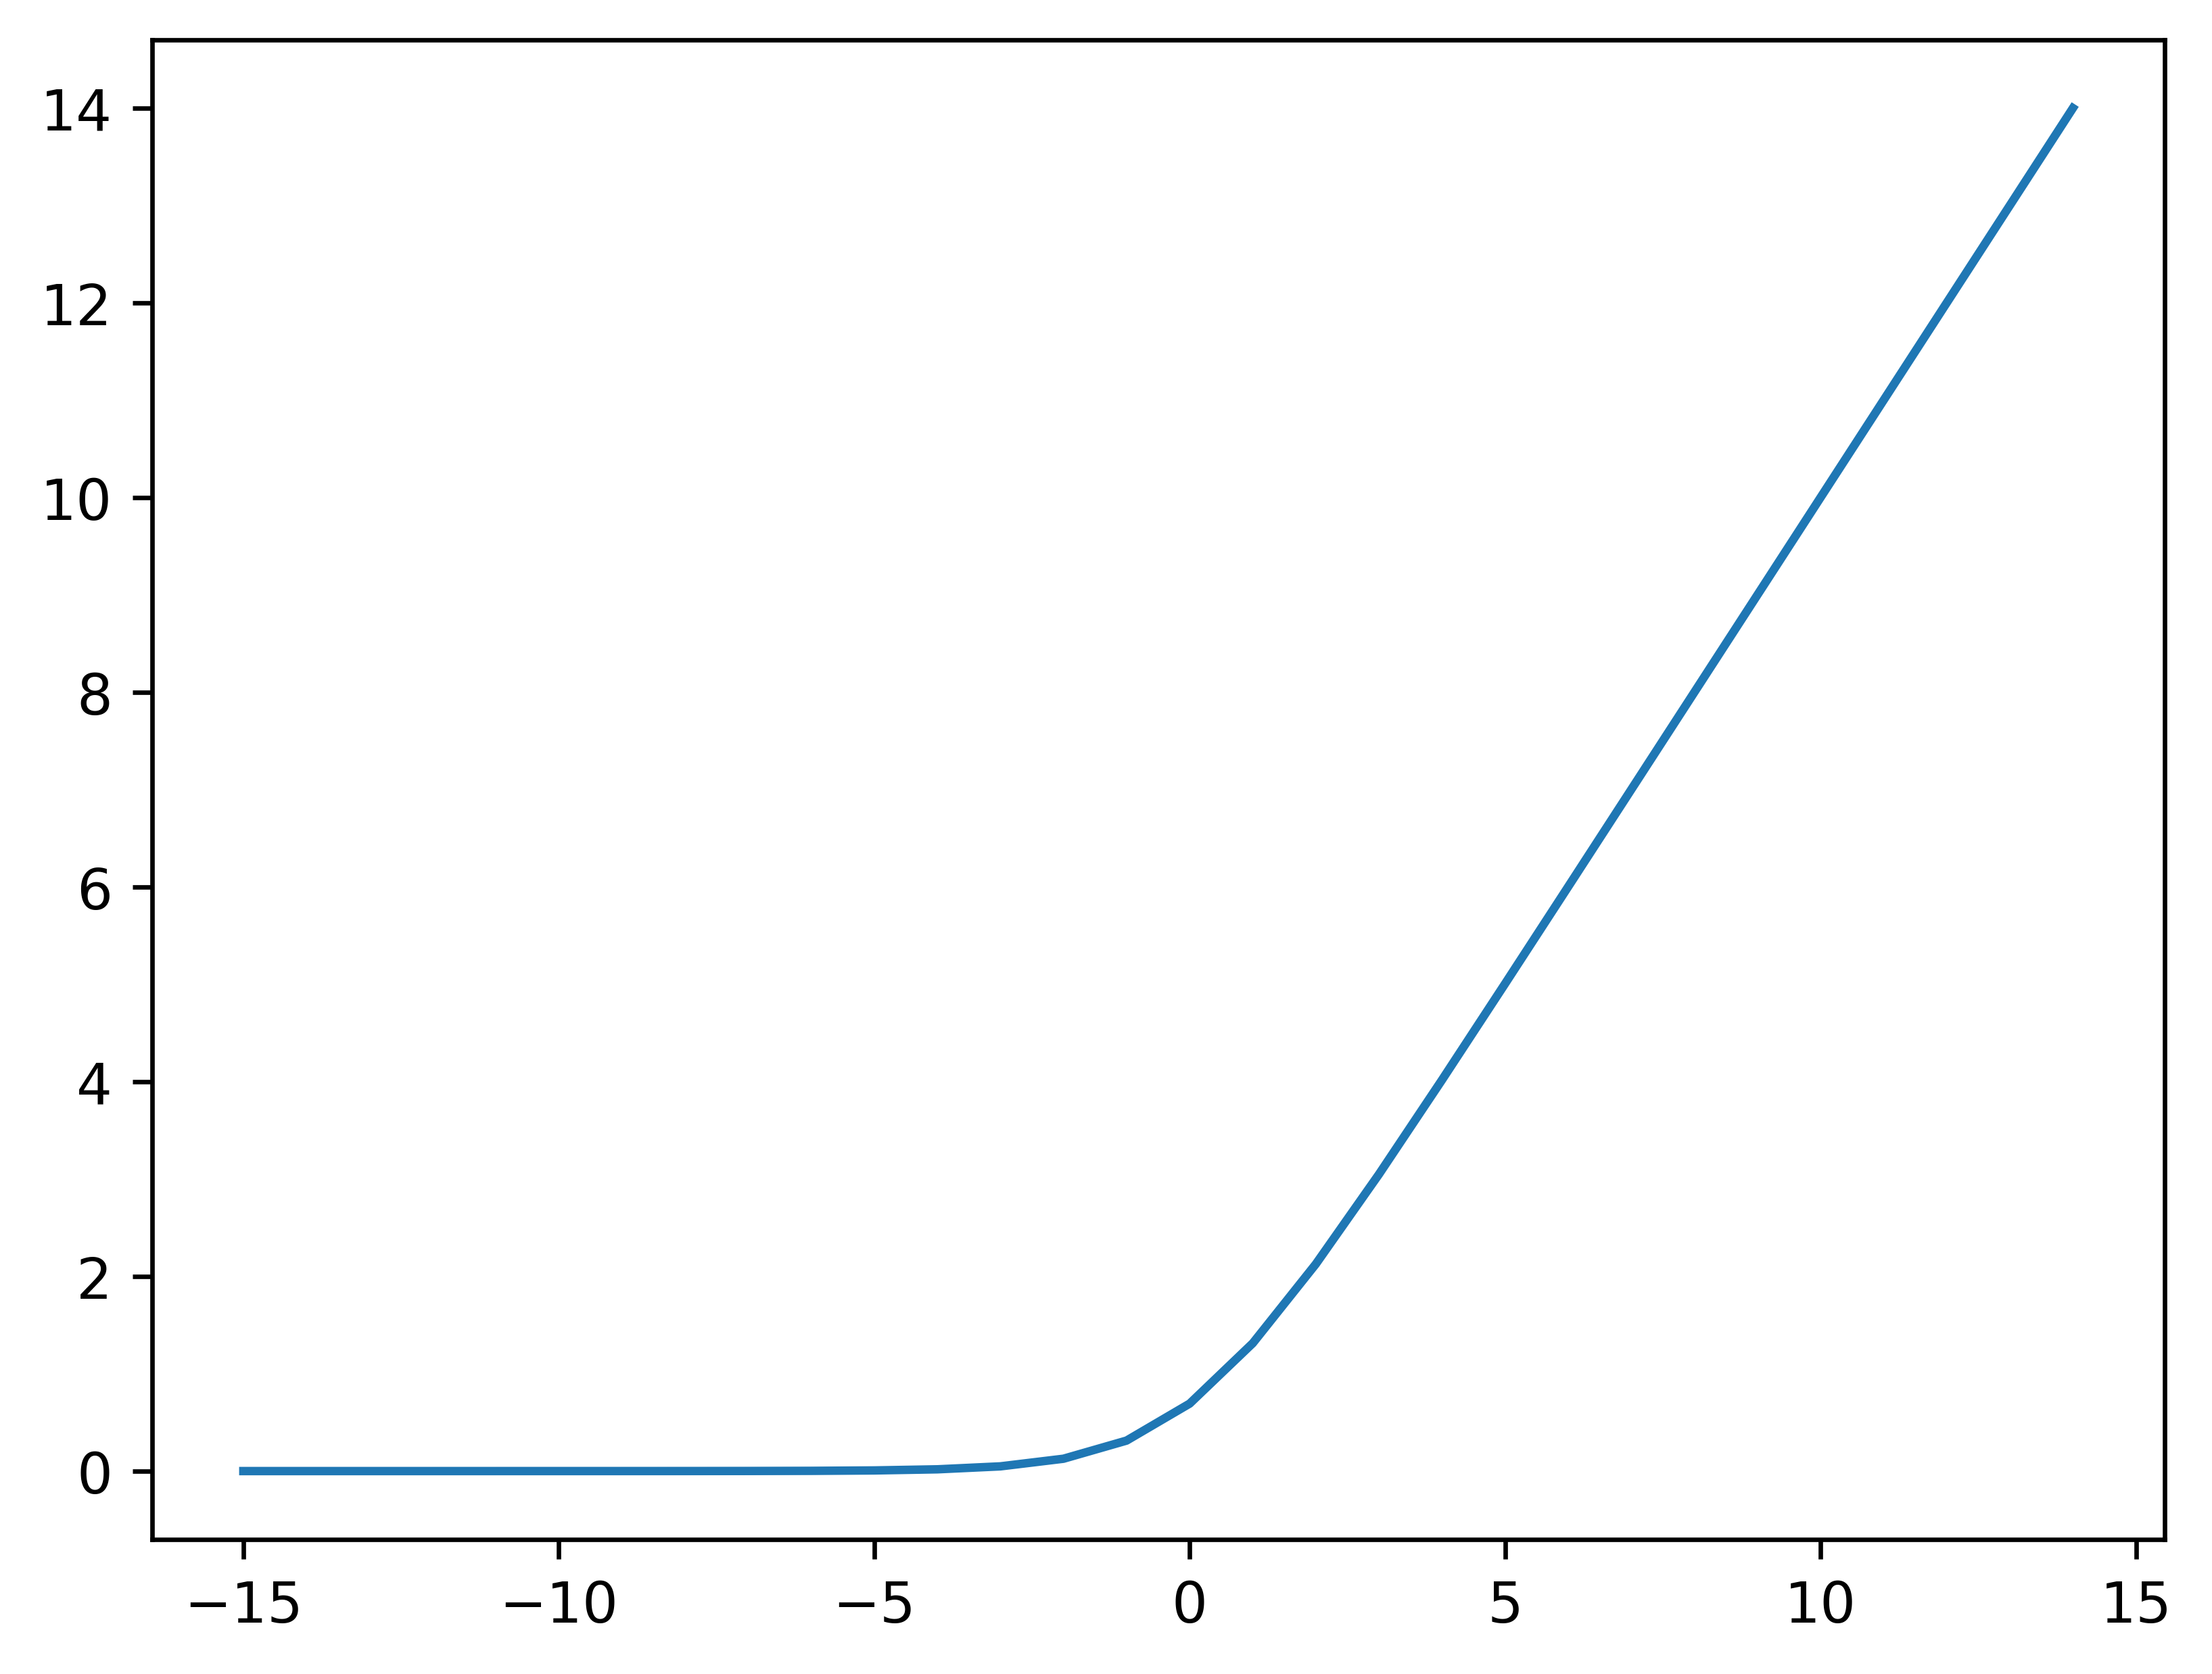

In [2]:
import torch
import matplotlib.pyplot as plt

x = torch.tensor(range(-15, 15))
plt.figure('softplus', dpi=600)
plt.plot(x, torch.log(1+torch.exp(x)))

In [3]:
import torch.nn as nn
torch.set_printoptions(edgeitems=2, linewidth=75)

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [4]:
n_samples = torch.numel(t_u)
n_val = int(n_samples*0.2)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 6,  5,  0,  7,  8,  3,  1, 10,  4]), tensor([9, 2]))

In [5]:
t_u_train = t_u[train_indices]
t_u_val = t_u[val_indices]

t_c_train = t_c[train_indices]
t_c_val = t_c[val_indices]

# normalize
t_un_train = t_u_train * 0.1
t_un_val = t_u_val * 0.1

In [6]:
linear_model = nn.Linear(in_features=1, out_features=1)
linear_model(t_un_val)

tensor([[-4.8510],
        [-4.6446]], grad_fn=<AddmmBackward0>)

In [7]:
linear_model.weight, linear_model.bias

(Parameter containing:
 tensor([[-0.9380]], requires_grad=True),
 Parameter containing:
 tensor([0.8144], requires_grad=True))

In [8]:
x = torch.tensor([1.0])
linear_model(x)

tensor([-0.1236], grad_fn=<AddBackward0>)

In [9]:
x = torch.ones(10, 1)
optimizer = torch.optim.SGD(linear_model.parameters(), lr=1e-2)
linear_model(x)

tensor([[-0.1236],
        [-0.1236],
        [-0.1236],
        [-0.1236],
        [-0.1236],
        [-0.1236],
        [-0.1236],
        [-0.1236],
        [-0.1236],
        [-0.1236]], grad_fn=<AddmmBackward0>)

In [10]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.9380]], requires_grad=True),
 Parameter containing:
 tensor([0.8144], requires_grad=True)]

In [11]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs+1):
        #循环开始，首先正向传播
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f'Epoch {epoch}, Training loss {loss_train.item():.4f}, '
                  f' Validation loss {loss_val.item():.4f}')


In [12]:
training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=linear_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val
)

Epoch 1, Training loss 309.0059,  Validation loss 352.2845
Epoch 1000, Training loss 3.5410,  Validation loss 2.6925
Epoch 2000, Training loss 2.9437,  Validation loss 2.9750
Epoch 3000, Training loss 2.9341,  Validation loss 3.0135


In [13]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[5.4096]], requires_grad=True),
 Parameter containing:
 tensor([-17.3941], requires_grad=True)]

In [14]:
seq_model = nn.Sequential(
    nn.Linear(1, 13),
    nn.Tanh(),
    nn.Linear(13, 1)
)

In [15]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [16]:
print(seq_model)

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)


In [17]:
from torchsummary import summary

In [18]:
device_name = torch.cuda.get_device_name(0)

In [19]:
device_name

'NVIDIA GeForce RTX 3050 Laptop GPU'

In [20]:
from collections import OrderedDict
import torch.nn as nn

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [21]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [22]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.1188], requires_grad=True)

In [24]:
optimizer = torch.optim.SGD(seq_model.parameters(), lr=1e-3)
training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val
)

Epoch 1, Training loss 193.7008,  Validation loss 209.1212
Epoch 1000, Training loss 4.5201,  Validation loss 3.7705
Epoch 2000, Training loss 4.3158,  Validation loss 4.9058
Epoch 3000, Training loss 1.7245,  Validation loss 3.2866
Epoch 4000, Training loss 1.6051,  Validation loss 3.2796
Epoch 5000, Training loss 1.5563,  Validation loss 3.2644


c:\Users\ElainaX\.conda\envs\pytorchEnv\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 21326 (\N{CJK UNIFIED IDEOGRAPH-534E}) missing from current font.
  func(*args, **kwargs)
c:\Users\ElainaX\.conda\envs\pytorchEnv\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 27663 (\N{CJK UNIFIED IDEOGRAPH-6C0F}) missing from current font.
  func(*args, **kwargs)
c:\Users\ElainaX\.conda\envs\pytorchEnv\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  func(*args, **kwargs)
c:\Users\ElainaX\.conda\envs\pytorchEnv\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 25668 (\N{CJK UNIFIED IDEOGRAPH-6444}) missing from current font.
  func(*args, **kwargs)
c:\Users\ElainaX\.conda\envs\pytorchEnv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21326 (\N{CJK UNIFIED IDEOGRAPH-534E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\User

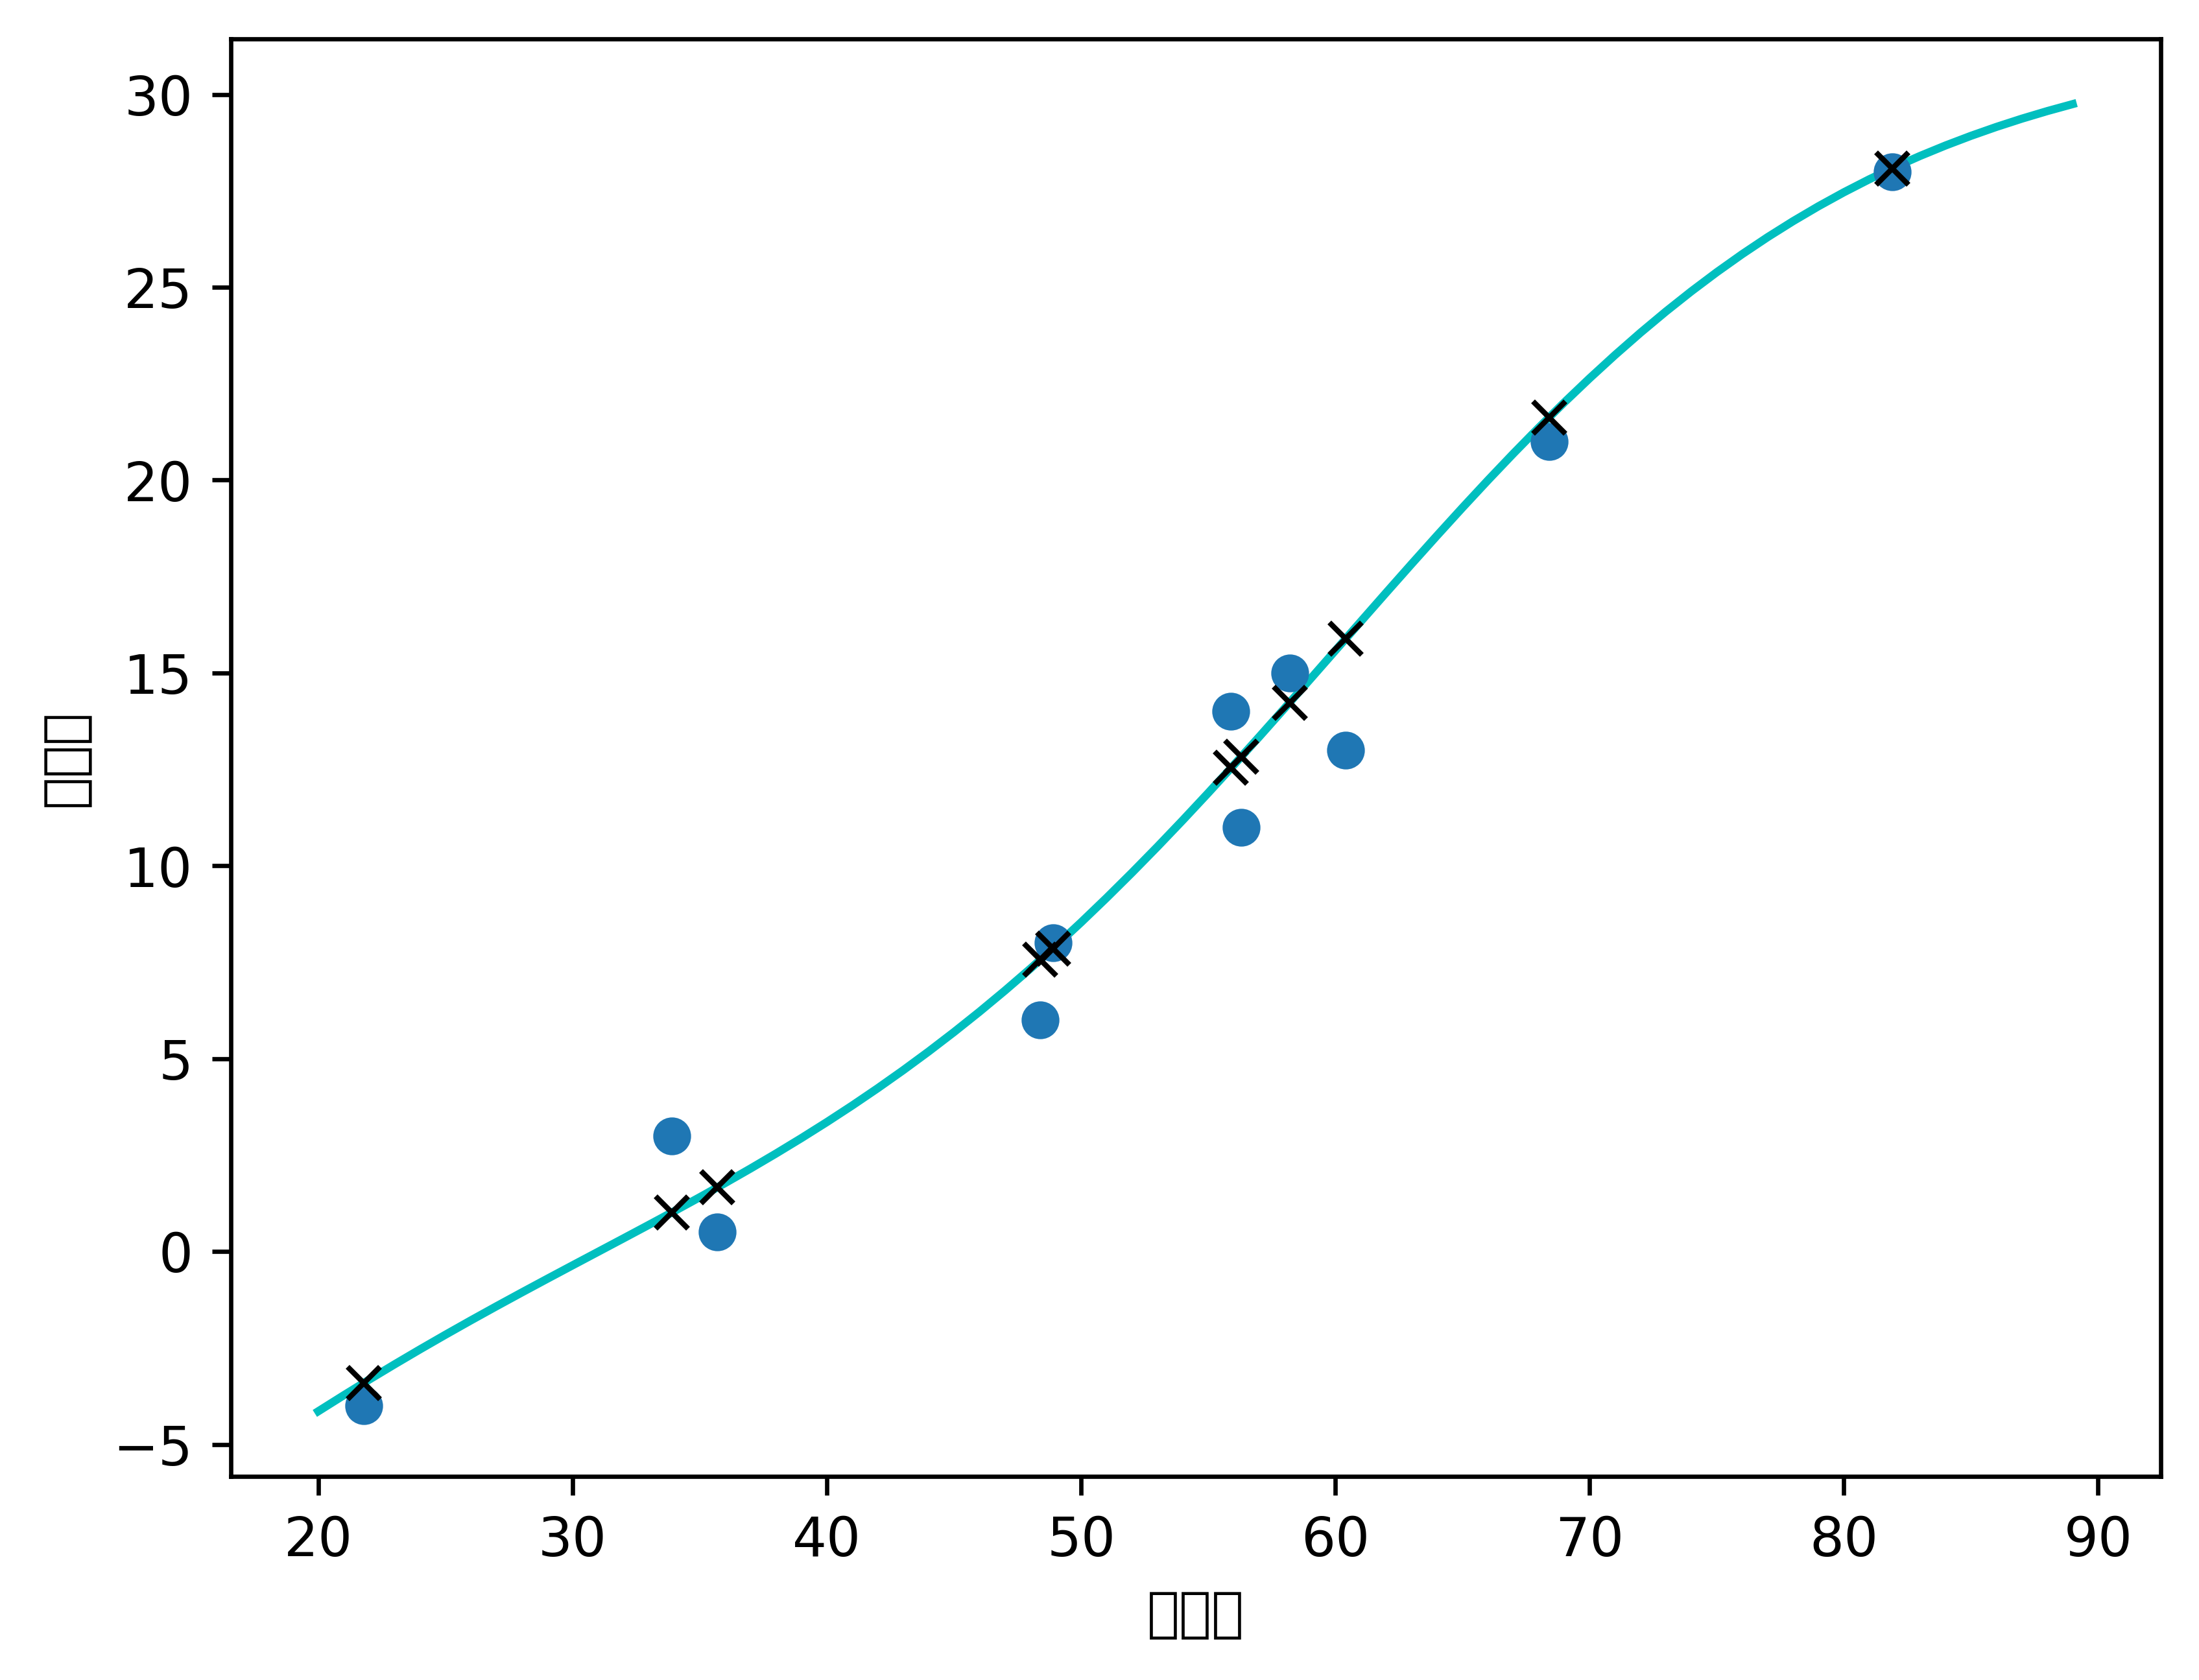

In [25]:
from matplotlib import pyplot as plt
t_range = torch.arange(20.0, 90.0).unsqueeze(1)
fig = plt.figure(dpi=600)
plt.xlabel('华氏度')
plt.ylabel('摄氏度')
plt.plot(t_range.numpy(), seq_model(t_range*0.1).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_u.numpy(), seq_model(0.1*t_u).detach().numpy(), 'kx')